In [9]:
# @title 1. Install Dependencies
!pip install -q kagglehub transformers datasets librosa torch torchaudio scikit-learn evaluate accelerate
print("Dependencies installed.")

Dependencies installed.


In [10]:
# @title 2. Download Dataset & Locate Files
import kagglehub
import os
import pandas as pd
import glob

# Download dataset
print("Downloading dataset... (This might take a while)")
dataset_path = kagglehub.dataset_download("mozillaorg/common-voice")
print(f"Dataset downloaded to: {dataset_path}")

# Mencari file CSV 'cv-valid-train.csv' secara otomatis di dalam folder unduhan
# Struktur file dataset ini biasanya terpisah menjadi folder 'cv-valid-train', etc.
search_pattern = os.path.join(dataset_path, "**", "cv-valid-train.csv")
csv_files = glob.glob(search_pattern, recursive=True)

if not csv_files:
    raise FileNotFoundError("Could not find 'cv-valid-train.csv'. Please check the dataset structure.")

csv_path = csv_files[0]
audio_dir = os.path.dirname(csv_path) # Folder tempat file mp3 berada (biasanya di folder yang sama atau subfolder)

# Jika mp3 ada di folder bernama 'cv-valid-train' di sebelah csv
if os.path.exists(os.path.join(audio_dir, "cv-valid-train")):
    audio_dir = os.path.join(audio_dir, "cv-valid-train")

print(f"Metadata found at: {csv_path}")
print(f"Audio directory expected at: {audio_dir}")

Using Colab cache for faster access to the 'common-voice' dataset.
Dataset downloaded to: /kaggle/input/common-voice
Metadata found at: /kaggle/input/common-voice/cv-valid-train.csv
Audio directory expected at: /kaggle/input/common-voice/cv-valid-train


In [11]:
# @title 3. Data Loading, Filtering & Balancing
import pandas as pd
import numpy as np

# Load metadata
df = pd.read_csv(csv_path)

# Filter hanya kolom yang dibutuhkan
df = df[['filename', 'accent', 'text']]

# Target Accents
target_accents = ['us', 'australia', 'england']
df_filtered = df[df['accent'].isin(target_accents)].copy()

# Cek distribusi data awal
print("Distribusi Awal:")
print(df_filtered['accent'].value_counts())

# --- SAMPLING STRATEGY ---
# Untuk mencapai akurasi tinggi namun tetap efisien di Colab,
# kita ambil jumlah sampel minimum dari kelas terkecil, atau batasi max n_samples.
# Kenny, jika RAM Colab 'High-RAM' tersedia, kamu bisa naikkan SAMPLES_PER_CLASS.
SAMPLES_PER_CLASS = 2500  # Cukup untuk fine-tuning wav2vec2 base

# Melakukan Balanced Sampling
df_balanced = df_filtered.groupby('accent').apply(
    lambda x: x.sample(min(len(x), SAMPLES_PER_CLASS), random_state=42)
).reset_index(drop=True)

print(f"\nDistribusi setelah sampling (Total: {len(df_balanced)}):")
print(df_balanced['accent'].value_counts())

# Update path filename agar absolut (memudahkan loading nanti)
df_balanced['path'] = df_balanced['filename'].apply(lambda x: os.path.join(audio_dir, x))

# Encoding Label (Text to ID)
label2id = {'us': 0, 'australia': 1, 'england': 2}
id2label = {0: 'us', 1: 'australia', 2: 'england'}

df_balanced['label'] = df_balanced['accent'].map(label2id)

# Split Train/Test (80/20)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label'])

print(f"\nTrain set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Distribusi Awal:
accent
us           30997
england      14938
australia     4287
Name: count, dtype: int64

Distribusi setelah sampling (Total: 7500):
accent
australia    2500
england      2500
us           2500
Name: count, dtype: int64

Train set size: 6000
Test set size: 1500


/tmp/ipython-input-1003255670.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_filtered.groupby('accent').apply(


In [12]:
# @title 4. Audio Processing Pipeline
from datasets import Dataset, Audio
from transformers import Wav2Vec2FeatureExtractor

# Konversi Pandas DF ke Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load Feature Extractor
model_checkpoint = "facebook/wav2vec2-base"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_checkpoint)

# --- FUNGSI PREPROCESSING UTAMA ---
# 1. Load Audio
# 2. Resample ke 16kHz
# 3. Truncate (potong) audio panjang (misal max 5 detik) untuk hemat VRAM

def preprocess_function(examples):
    import librosa

    audio_arrays = []

    # Loop melalui path file
    for path in examples['path']:
        # Load menggunakan librosa (lebih stabil untuk mp3 di colab dibanding torchaudio default)
        # sr=16000 adalah syarat wajib Wav2Vec 2.0
        speech, _ = librosa.load(path, sr=16000, duration=5.0) # Limit durasi 5 detik
        audio_arrays.append(speech)

    # Feature Extraction (Normalisasi & Padding)
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=16000,
        padding=True,
        max_length=16000*5, # 5 detik * 16kHz
        truncation=True,
        return_tensors="pt"
    )

    return {
        "input_values": inputs.input_values,
        "labels": examples["label"]
    }

# Terapkan fungsi ke dataset (batched=True mempercepat proses)
print("Processing training data...")
encoded_train = train_dataset.map(preprocess_function, batched=True, batch_size=8, remove_columns=train_dataset.column_names)
print("Processing test data...")
encoded_test = test_dataset.map(preprocess_function, batched=True, batch_size=8, remove_columns=test_dataset.column_names)

print("Data processing complete.")

Processing training data...


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Processing test data...


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Data processing complete.


=== SAMPLE INDEX: 5238 ===
Label/Accent : england
Original Path: /kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-168783.mp3


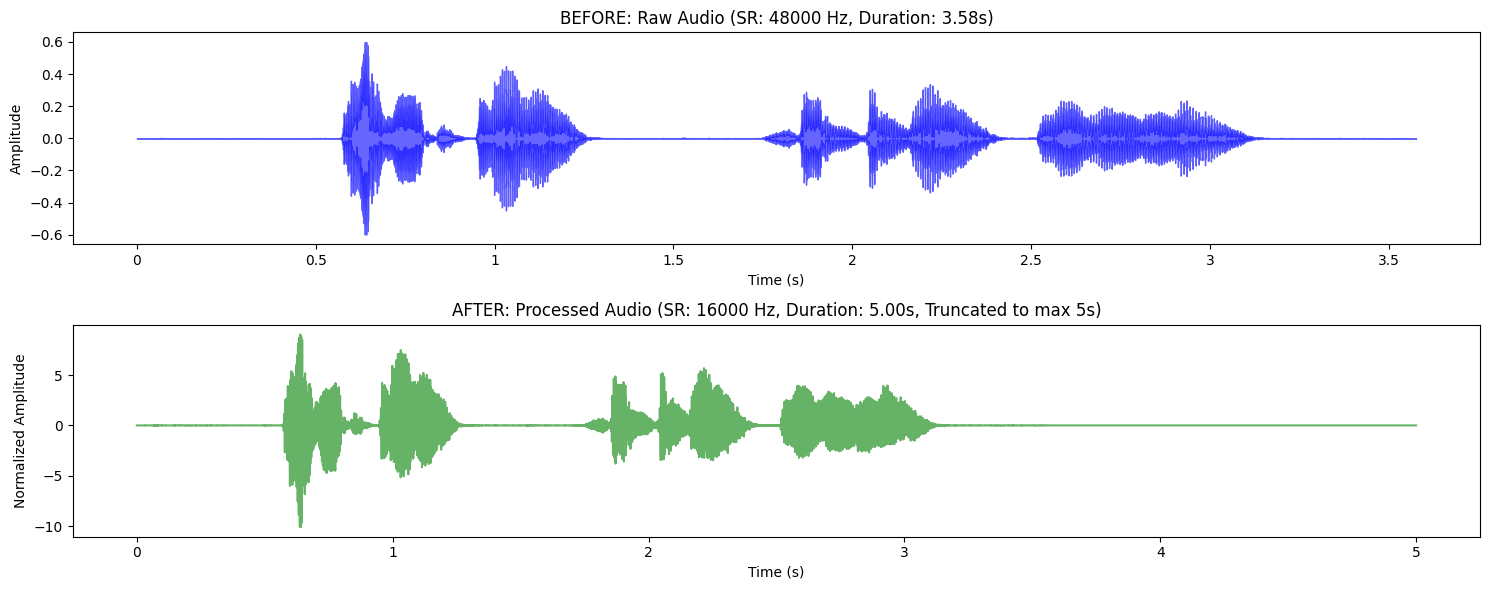


--- Audio Playback ---
1. Original Audio (High Quality):



2. Processed Audio (16kHz & Truncated):


In [13]:
# @title 4.5. Visualize & Listen: Before vs After
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import random
import numpy as np

# Ambil satu sampel acak dari data training
idx = random.randint(0, len(train_df) - 1)

# --- 1. DATA SEBELUM PROCESSING (RAW) ---
# Ambil path dari dataframe asli
raw_path = train_df.iloc[idx]['path']
original_label = id2label[train_df.iloc[idx]['label']]

# Load dengan sampling rate asli (sr=None)
y_raw, sr_raw = librosa.load(raw_path, sr=None)

print(f"=== SAMPLE INDEX: {idx} ===")
print(f"Label/Accent : {original_label}")
print(f"Original Path: {raw_path}")

# --- 2. DATA SETELAH PROCESSING (Wav2Vec Ready) ---
# Ambil dari dataset yang sudah di-encode
# Note: HuggingFace dataset mengembalikan list/tensor, kita ubah ke numpy
processed_input = np.array(encoded_train[idx]['input_values'])
sr_processed = 16000 # Wav2Vec2 fix di 16kHz

# --- 3. PLOTTING ---
plt.figure(figsize=(15, 6))

# Plot Raw
plt.subplot(2, 1, 1)
librosa.display.waveshow(y_raw, sr=sr_raw, color='blue', alpha=0.6)
plt.title(f"BEFORE: Raw Audio (SR: {sr_raw} Hz, Duration: {len(y_raw)/sr_raw:.2f}s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot Processed
plt.subplot(2, 1, 2)
# Kita perlu membuat axis waktu manual karena input_values tidak menyimpan sr
time_axis = np.linspace(0, len(processed_input) / sr_processed, num=len(processed_input))
plt.plot(time_axis, processed_input, color='green', alpha=0.6)
plt.title(f"AFTER: Processed Audio (SR: {sr_processed} Hz, Duration: {len(processed_input)/sr_processed:.2f}s, Truncated to max 5s)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.tight_layout()
plt.show()

# --- 4. AUDIO PLAYER ---
print("\n--- Audio Playback ---")
print("1. Original Audio (High Quality):")
ipd.display(ipd.Audio(y_raw, rate=sr_raw))

print("\n2. Processed Audio (16kHz & Truncated):")
ipd.display(ipd.Audio(processed_input, rate=sr_processed))

In [14]:
# @title 5. Model Setup & Metrics
from transformers import Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

# Load Metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Load Model untuk Klasifikasi (3 Kelas)
num_labels = 3
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)

# Freeze Feature Extractor?
# Opsional: Freeze layer awal (CNN) untuk mempercepat training dan mencegah overfitting pada data kecil.
# model.freeze_feature_extractor()
print("Model loaded and feature extractor frozen.")

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and feature extractor frozen.


In [15]:
# @title 6. Training Execution
import os
from transformers import TrainingArguments, Trainer
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./wav2vec2_accent_classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    fp16=True,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    processing_class=feature_extractor,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.586900,0.536301,0.807333
2,0.611300,0.495756,0.846667
3,0.296100,0.612076,0.844667
4,0.185700,0.473550,0.896667
5,0.110500,0.702881,0.857333
6,0.127300,0.539562,0.901333
7,0.208400,0.537217,0.913333
8,0.001300,0.525241,0.912667


TrainOutput(global_step=6000, training_loss=0.3298875443140666, metrics={'train_runtime': 4408.5446, 'train_samples_per_second': 10.888, 'train_steps_per_second': 1.361, 'total_flos': 2.17887775488e+18, 'train_loss': 0.3298875443140666, 'epoch': 8.0})

Running final evaluation...



Final Accuracy on Test Set: 0.9133

Classification Report:
              precision    recall  f1-score   support

          us       0.95      0.90      0.92       500
   australia       0.91      0.94      0.92       500
     england       0.89      0.90      0.90       500

    accuracy                           0.91      1500
   macro avg       0.91      0.91      0.91      1500
weighted avg       0.91      0.91      0.91      1500



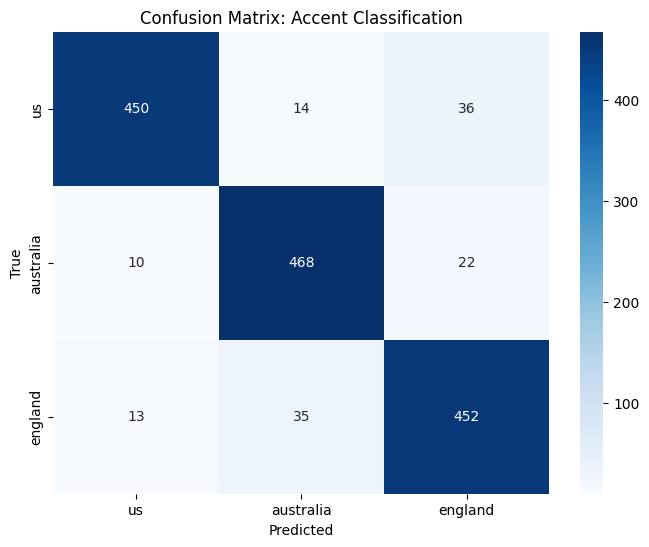


Demo Prediction for file: /kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-048954.mp3
True Label: us
Predicted: us (Confidence: 99.87%)


In [16]:
# @title 7. Final Evaluation & Detailed Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Prediksi pada test set
print("Running final evaluation...")
predictions = trainer.predict(encoded_test)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Hitung Akurasi
final_acc = accuracy_metric.compute(predictions=preds, references=true_labels)
print(f"\nFinal Accuracy on Test Set: {final_acc['accuracy']:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=target_accents))

# Confusion Matrix Visualization
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_accents, yticklabels=target_accents)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Accent Classification')
plt.show()

# --- DEMO PREDICTION ON SINGLE FILE (Example) ---
def predict_file(file_path):
    import librosa
    # Preprocess
    speech, _ = librosa.load(file_path, sr=16000, duration=5.0)
    inputs = feature_extractor(speech, sampling_rate=16000, return_tensors="pt", padding=True)

    # Move inputs to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    # Inference
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = torch.argmax(logits, dim=-1).item()
    confidence = torch.nn.functional.softmax(logits, dim=-1)[0][predicted_class_id].item()

    return id2label[predicted_class_id], confidence

# Test with a sample from test set (mengambil file asli dari dataframe test)
sample_file = test_df.iloc[0]['path']
print(f"\nDemo Prediction for file: {sample_file}")
pred_label, conf = predict_file(sample_file)
print(f"True Label: {id2label[test_df.iloc[0]['label']]}")
print(f"Predicted: {pred_label} (Confidence: {conf:.2%})")